# Goal

* Getting beta-diversity median +/- variance for each host clade

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S/intra_host_variance/beta_div/'

# phyloseq of all taxa
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# distance matrices
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/beta_div.RDS'

# misc
threads = 4

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Load

## Metadata

In [3]:
metadata = readRDS(physeq_file) %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(SampleID = rownames(.))
metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 172


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,SampleID
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,X1.Eurasian.Beaver
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,X101.Horse
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,X102.Kulan


## Distance matrices

In [4]:
# load beta-diversity dist. matrices
beta_d = readRDS(beta_div_file)

# status
lapply(beta_d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


# Formatting

In [5]:
# converting distance matrix from triangle to long format
dist2long = function(d){
    L = d %>% labels
    L = expand.grid(L, L)
    x = cbind(L, d %>% as.matrix %>% as.vector)
    colnames(x) = c('Var1', 'Var2', 'Value')
    return(x)
}

d_l = lapply(beta_d, dist2long)
d_l %>% length

[1] 4

In [6]:
# combining into 1 df
df = do.call(rbind, d_l) %>%
    mutate(metric = gsub('\\.[0-9]+$', '', rownames(.)),
           Value = Value %>% as.Num)

# renaming distances
old_names = c('jaccard', 'bray_curtis', 'unweighted_unifrac', 'weighted_unifrac')
new_names = c('Jaccard', 'Bray Curtis', 'Unweighted\nUnifrac', 'Weighted\nUnifrac')
tmp = data.frame(old_names, new_names)

df = df %>%
    inner_join(tmp, c('metric'='old_names')) %>%
    dplyr::select(-metric) %>%
    rename('metric' = new_names) 

df %>% status

Warning message:
“Column `metric`/`old_names` joining character vector and factor, coercing into character vector”

[1] 181476      4


Var1,Var2,Value,metric
X1.Eurasian.Beaver,X1.Eurasian.Beaver,0.0000,Bray Curtis
X101.Horse,X1.Eurasian.Beaver,0.9984,Bray Curtis
X102.Kulan,X1.Eurasian.Beaver,0.9990,Bray Curtis


In [7]:
# filtering: no self-self
df = df %>%
    filter(Var1 != Var2) 

df %>% status

[1] 180624      4


Var1,Var2,Value,metric
X101.Horse,X1.Eurasian.Beaver,0.9984,Bray Curtis
X102.Kulan,X1.Eurasian.Beaver,0.9990,Bray Curtis
X109.Red.Fox,X1.Eurasian.Beaver,0.9986,Bray Curtis


## Adding taxonomy

In [8]:
tmp = metadata %>%
    distinct(SampleID, class, order, family, genus, scientific_name) %>%
    rename('Class' = class,
           'Order' = order,
           'Family' = family,
           'Genus' = genus,
           'Species' = scientific_name)

tmp %>% status

[1] 213   6


Species,Class,Order,Family,Genus,SampleID
Castor_fiber,Mammalia,Rodentia,Castoridae,Castor,X1.Eurasian.Beaver
Equus_caballus,Mammalia,Perissodactyla,Equidae,Equus,X101.Horse
Equus_hemionus,Mammalia,Perissodactyla,Equidae,Equus,X102.Kulan


In [9]:
# adding taxonomy
df = df %>%
    inner_join(tmp, c('Var1'='SampleID')) %>%
    inner_join(tmp, c('Var2'='SampleID')) 

df %>% status

Warning message:
“Column `Var1`/`SampleID` joining factor and character vector, coercing into character vector”Warning message:
“Column `Var2`/`SampleID` joining factor and character vector, coercing into character vector”

[1] 180624     14


Var1,Var2,Value,metric,Species.x,Class.x,Order.x,Family.x,Genus.x,Species.y,Class.y,Order.y,Family.y,Genus.y
X101.Horse,X1.Eurasian.Beaver,0.9984,Bray Curtis,Equus_caballus,Mammalia,Perissodactyla,Equidae,Equus,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor
X102.Kulan,X1.Eurasian.Beaver,0.9990,Bray Curtis,Equus_hemionus,Mammalia,Perissodactyla,Equidae,Equus,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor
X109.Red.Fox,X1.Eurasian.Beaver,0.9986,Bray Curtis,Vulpes_vulpes,Mammalia,Carnivora,Canidae,Vulpes,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor


# Summarize by clade

In [10]:
# ID which are within vs between clades
df_s = df %>%
    mutate(Class = Class.x == Class.y,
           Order = Order.x == Order.y,
           Family = Family.x == Family.y,
           Genus = Genus.x == Genus.y,
           Species = Species.x == Species.y) %>%
    dplyr::select(Var1, Var2, Value, metric,
                  Class, Order, Family, Genus, Species)

df_s %>% status

[1] 180624      9


Var1,Var2,Value,metric,Class,Order,Family,Genus,Species
X101.Horse,X1.Eurasian.Beaver,0.9984,Bray Curtis,TRUE,FALSE,FALSE,FALSE,FALSE
X102.Kulan,X1.Eurasian.Beaver,0.9990,Bray Curtis,TRUE,FALSE,FALSE,FALSE,FALSE
X109.Red.Fox,X1.Eurasian.Beaver,0.9986,Bray Curtis,TRUE,FALSE,FALSE,FALSE,FALSE


In [11]:
# values within each clade
within_each_clade = function(lev, df_s){
    x = df_s[df_s[,lev] == TRUE, c('metric', 'Value')] 
    x = as.data.frame(as.matrix(x))
    x$Level = lev
    return(x)
}

levs = c('Class', 'Order', 'Family', 'Genus', 'Species')
df_s = lapply(as.list(levs), within_each_clade, df_s=df_s)
df_s = do.call(rbind, df_s)

df_s %>% status

[1] 128552      3


metric,Value,Level
Bray Curtis,0.99840000,Class
Bray Curtis,0.99900000,Class
Bray Curtis,0.99860000,Class


In [12]:
# summarizing
df_s = df_s %>%
    mutate(Value = Value %>% as.Num) %>%
    group_by(Level, metric) %>%
    summarize(median = median(Value),
              n = length(Value),
              sd = sd(Value),
              stderr = sd(Value) / sqrt(length(Value))) %>%
    ungroup() 

df_s %>% status

[1] 20  6


Level,metric,median,n,sd,stderr
Class,Bray Curtis,1.0000000,26474,0.05563016,0.0003419011
Class,Jaccard,1.0000000,26474,0.03578367,0.0002199253
Class,Unweighted Unifrac,0.8234807,26474,0.10718287,0.0006587424


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/2_intra_host_variance/2_beta_div/.figures/beta-div_by-clade_pointrange.pdf 


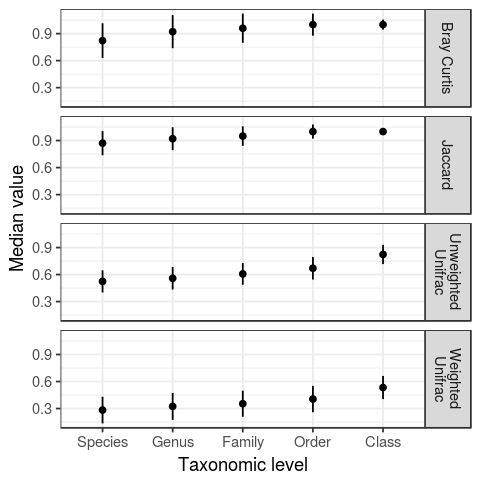

In [13]:
# plotting
df_s$Level = factor(df_s$Level, levels = rev(levs))

p = ggplot(df_s, aes(Level, median)) +
    geom_linerange(aes(ymin = median - sd,
                       ymax = median + sd)) +
    geom_point() +
    labs(x='Taxonomic level', y='Median value') +
    facet_grid(metric ~ .) +
    theme_bw()

options(repr.plot.width=4, repr.plot.height=4)
plot_write(p, file='beta-div_by-clade_pointrange.pdf')

# SessionInfo

In [14]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2    phyloseq_1.22.3 ggplot2_2.2.1   tidyr_0.8.1    
[5] dplyr_0.7.4    

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-1        repr_0.12.0         purrr_0.2.4        
 [4] reshape2_1